In [ ]:
pip install keras_applications 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
#from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
import os
from keras.layers import *

In [ ]:
def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    #plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    #plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    #plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')
    
def get_base_model(model_name,image_size):
    if model_name =='vgg16':
        base_model=VGG16              (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='resnet50':
        base_model=ResNet50           (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='xception':
        base_model=Xception           (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='densenet121':    #done acc = 55% epochs:30
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='mobilenet0.75': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=0.75,input_shape=(image_size,image_size,3))
    if model_name =='mobilenet1.0': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='mobilenetv2':
        base_model=MobileNetV2      (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='inceptionv3':   
        base_model=InceptionV3       (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='inceptionv2':
        base_model=tf.keras.applications.InceptionResNetV2 (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='efficientnetB0':
        base_model = tf.keras.applications.EfficientNetB0 (include_top=False, weights = 'imagenet',input_shape = (image_size,image_size,3))
    if model_name =='efficientNetV2B0':
        base_model = tf.keras.applications.EfficientNetV2B0 (include_top=False, weights = 'imagenet',input_shape = (image_size,image_size,3))
    if model_name =='nasnet':
        base_model=tf.keras.applications.NASNetMobile (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    
    return base_model

def train_model(model,dataset,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
    
    dataParam={'messidor': [960,240,2,'../content/drive/MyDrive/Mtech Project/Dataset/Messidor_Binary_512/train',
                            '../content/drive/MyDrive/Mtech Project/Dataset/Messidor_Binary_512/test'],
               'kaggle': [30000,5126,5,'./data/kaggle/train','./data/kaggle/valid'],
               'DDR':   [9851,2503,5,'./data/DDR/train','./data/DDR/valid']} 
    
    train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)          
    valid = ImageDataGenerator()
    train_data=train.flow_from_directory(train_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = True,
                                         batch_size=batch_size)
    valid_data=valid.flow_from_directory(test_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = False,
                                         batch_size=batch_size)

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    #save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=10)
    
    filepath = "efficientNetV2B0_baseline.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc',verbose=1, save_best_only=True, mode='max')

    for layer in base_model.layers:
        layer.trainable = False   
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
    model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs1, 
                        workers=2,
                        callbacks=[lr_decay,checkpoint])   
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history=model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs2,
                        workers=2,
                        callbacks=[lr_decay,checkpoint])
    
    score = model.evaluate(valid_data,batch_size = 64)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history,model,valid_data

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"    
loss_fun= 'binary_crossentropy'  
gpu_num=1
k=3
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=512
classes=2

base_model=get_base_model('efficientNetV2B0',image_size)  
base_in=base_model.input
base_out=base_model.output

shape=K.int_shape(base_out)  
x=GlobalAveragePooling2D()(base_out)
out=Dense(classes,activation='softmax')(x)

parallel_model=keras.Model(base_model.input,out)
parallel_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 256, 256, 32  864         ['normalization[0][0]']      

In [ ]:
history,model,valid_data=train_model(parallel_model,
                                     'messidor',
                                     image_size,
                                     batch_size,
                                     'efficientNetV2B0',
                                     lr1,lr2,1,80)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
60/60 [==============================] - ETA: 0s - loss: 0.3845 - acc: 0.8167
Epoch 1: acc improved from -inf to 0.81667, saving model to efficientNetV2B0_baseline.hdf5
60/60 [==============================] - 69s 932ms/step - loss: 0.3845 - acc: 0.8167 - lr: 0.0050
Epoch 1/80
60/60 [==============================] - ETA: 0s - loss: 0.3888 - acc: 0.8313
Epoch 1: acc improved from 0.81667 to 0.83125, saving model to efficientNetV2B0_baseline.hdf5
60/60 [==============================] - 85s 1s/step - loss: 0.3888 - acc: 0.8313 - lr: 1.0000e-04
Epoch 2/80
60/60 [==============================] - ETA: 0s - loss: 0.3209 - acc: 0.8552
Epoch 2: acc improved from 0.83125 to 0.85521, saving model to efficientNetV2B0_baseline.hdf5
60/60 [==============================] - 73s 1s/step - loss: 0.3209 - acc: 0.8552 - lr: 1.0000e-04
Epoch 3/80
60/60 [==============================] - ETA: 0s - loss: 0.3037 - acc: 0.878

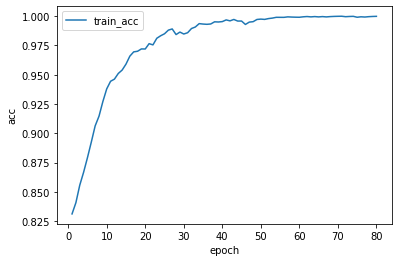

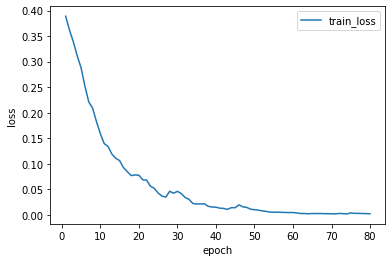

In [ ]:
plotmodel(history,'efficientnetv2L')            

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

Y_pred = model.predict(valid_data, 240 // 4)
#print(Y_pred.shape)
#print(type(Y_pred))
print(valid_data.classes)  
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)
print('Confusion Matrix')
matrix = confusion_matrix(valid_data.classes, y_pred)

print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = ['non-referable', 'referable']
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[9.98416066e-01 1.58394908e-03]
 [1.00000000e+00 7.54348584e-09]
 [9.99994397e-01 5.57814201e-06]
 [1.00000000e+00 6.51821119e-29]
 [1.00000000e+00 2.04545192e-14]
 [1.00000000e+00 2.24192331e-09]
 [1.00000000e+00 1.55046928e-13]
 [4.27382113e-03 9.95726228e-01]
 [9.99811828e-01 1.88207210e-04]
 [9.99999881e-01 6.55497203e-08]
 [9.99028802e-01 9.71214729e-04]
 [1.00000000e+00 3.02706110e-10]
 [1.00000000e+00 3.85421702e-13]
 [1.00000000e+00 1.48042245e-09]
 [1.00000000e+00 2.10552378e-22]
 [1.74142960e-02 

Text(69.0, 0.5, 'Truth')

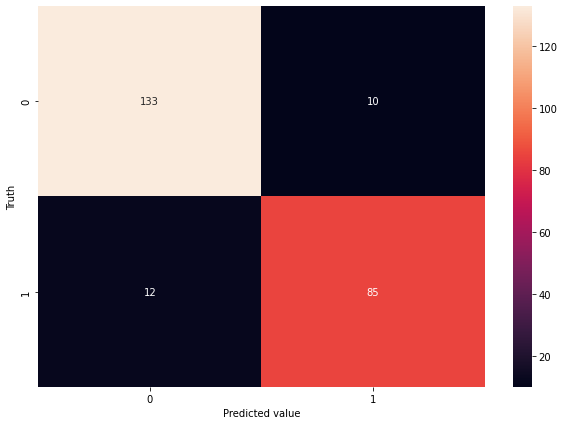

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(matrix,annot=True,fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Truth')   

In [ ]:
pip install plot_metric

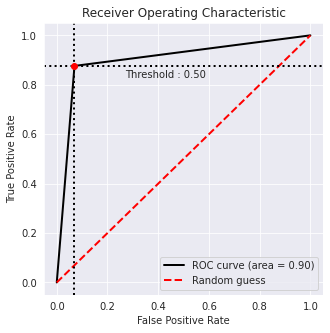

In [ ]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
y_true = valid_data.classes
y_probas = y_pred
bc = BinaryClassification(y_true, y_probas, labels=['non-referable', 'referable'])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [ ]:
import cv2

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
image = cv2.imread('../content/drive/MyDrive/Mtech Project/Dataset/Messidor_Binary_512/test/0/20051130_60234_0400_PP.tif')
model = parallel_model
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

In [ ]:
image = cv2.imread('../content/drive/MyDrive/Mtech Project/Dataset/Messidor_Binary_512/test/0/20051130_60234_0400_PP.tif')
image = cv2.resize(image, (512, 512))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = parallel_model.predict(image) 
i = np.argmax(preds[0])

'''for idx in range(len(parallel_model.layers)):
  print(parallel_model.get_layer(index = idx).name)'''

icam = GradCAM(parallel_model, i, 'conv2d_1') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (512, 512))

image = cv2.imread('../content/drive/MyDrive/Mtech Project/Dataset/Messidor_Binary_512/test/0/20051130_60234_0400_PP.tif')
image = cv2.resize(image, (512, 512))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(3, 6)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)